In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# CARGAR DATOS

**DATOS DE ENTRENAMIENTO**


**control**:     0

**depresión**:   1

**ansiedad** :   2




In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /Data: A D C/train.csv'
data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97543 entries, 0 to 97542
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     65054 non-null  object 
 1   TWEET_ID    64990 non-null  float64
 2   TWEET_TEXT  97479 non-null  object 
 3   trastorno   97543 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.0+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,RT @FraRocanroleras: Te estás destruyendo y lo...,1
1,6,2.147484e+09,No sé cómo estar sin ti pero tampoco sé cómo e...,0
2,NaN,NaN,Me pregunto por qué últimamente no me siento ...,2
3,NaN,NaN,Mi ansiedad en torno a toda esta enfermedad s...,2
4,NaN,NaN,Esto ha estado en mi mente bastante durante lo...,2
5,NaN,NaN,¿Necesitas algunas ideas? Este canal es maravi...,2
6,31,2.147484e+09,"Intenté decir algo pero no pude,sólo quedé con...",0
7,27,2.147484e+09,tumblrbot ha preguntado: ROBOTS OR DINOSAURS? ...,1
8,49,2.147484e+09,El smirnoff es la bebida mas traicionera que e...,1
9,36,2.147484e+09,¿Por qué mis primas son delgadas y tan hermosa...,0


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'trastorno'
null_values = data_train['trastorno'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'trastorno':", null_values)

Número de filas nulas o vacías en la columna 'trastorno': 0


# Preparación de los datos

In [ ]:
import nltk
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_en = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


*Eliminar etiquedas HTML*

In [ ]:
import re

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

*Limpiar texto*

In [ ]:
import re
import string

def clean(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)

        # Eliminar URLs o enlaces
        text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

        # Eliminar nombres de usuarios de Twitter
        text = re.sub(r'@\w+', '', text)

        # Eliminar Nombres propios
        text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

        # Eliminar todos los caracteres especiales
        text = re.sub(r'[^\w\s]+', '', text)

        # Eliminar prefijos y números
        text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

        # Eliminar palabras específicas
        specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                          'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                          'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                          'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                          'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                          'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                          'it','we','they','the','and','that','these','those','tweet','followed','follower']
        text = ' '.join([word for word in text.split() if word not in specific_words])

        # Eliminar emojis
        emojis = re.findall(r'[^\w\s,]', text)
        cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                     '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                     ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
        for emoji in cleaned_emojis:
            text = text.replace(emoji, '')

        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar signos de puntuación
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

        words = text.split() #divide el texto en palabras individuales, creando una lista de palabras.

      # Combinar las stopwords en  español
        all_stopwords = stopwords_en
      # Filtrar las stopwords del texto
        filtered_words = [word for word in words if word.lower() not in all_stopwords] #filtra las palabras vacías del texto que no están en la lista de palabras vacías

        # Unir las palabras filtradas en un solo texto
        text = ' '.join(filtered_words)

        # Devuelve el texto limpio
        return text
    else:
        return text  # Devolver el valor original si no es de tipo string

#Elaboración de la lista de palabras relevantes a partir de una bolsa de palabras del mismo conjunto de datos

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

# Inicializar stemmer de NLTK
stemmer = PorterStemmer()

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))
def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gato', 'saltar', 'valla']


# Preprocesamieto del conjunto de datos de entrenamiento

In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(removeHTML)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(clean)
#data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(extractTerms)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].astype(str)

data_train.head(10)

,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,destruyendo único haces reírte,1
1,6,2.147484e+09,cómo tampoco cómo contigo,0
2,NaN,NaN,pregunto últimamente siento tranquilo punto au...,2
3,NaN,NaN,ansiedad torno toda enfermedad disparado,2
4,NaN,NaN,mente bastante últimos meses compañero cuarto ...,2
5,NaN,NaN,ideas canal maravilloso aquí historias siguen ...,2
6,31,2.147484e+09,intenté decir pudesólo quedé nudo garganta lág...,0
7,27,2.147484e+09,tumblrbot preguntado robots dinosaurs,1
8,49,2.147484e+09,smirnoff bebida mas traicionera existe chabon ...,1
9,36,2.147484e+09,primas delgadas tan hermosas vidas,0


# Representación de los datos mediante una matriz BoW

e procederá a construir un conjunto de entrenamiento a partir de la representación de bolsa de palabras o inglés (Bag of Words.)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def Tokenizer(text):
    return text.split()  # Tokenizador simple: divide el texto en palabras
# Crear un transformador CountVectorizer con el tokenizer Tokenizery rango de n-gramas (1, 1)
# y un umbral de frecuencia mínimo de 200
umbral = 20
count_vect = CountVectorizer(tokenizer=Tokenizer, ngram_range=(1, 1), min_df=umbral)

# Aplicar el CountVectorizer a la columna 'TWEET_TEXT' en data_train y obtener la matriz BoW
bow_train = count_vect.fit_transform(data_train['TWEET_TEXT'].values)

# Imprimir el tamaño del vocabulario construido por CountVectorizer
print("El tamaño del vocabulario es:", len(count_vect.vocabulary_))

# Crear arrays X y y para los datos y etiquetas respectivamente
X = bow_train  # Matriz BoW
y = data_train['trastorno'].values  # Etiquetas de trastorno de la columna 'trastorno'

El tamaño del vocabulario es: 4657


# Entrenamiento y validación del modelo

In [ ]:
from sklearn.model_selection import train_test_split

#
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.25)

# Aprendizaje del modelo: Bosque Aletorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(
    n_estimators=300,  # Número de árboles
    max_depth=100,  # Profundidad máxima de los árboles
    random_state=42,  # Semilla aleatoria para reproducibilidad
    n_jobs=-1  # Utilizar todos los núcleos de la CPU para procesamiento en paralelo
)

# Entrena el modelo con los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula e imprime la precisión del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Precisión (Validación): {:.2f}".format(accuracy))

# Calcula e imprime la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred, average='weighted')
print("Precisión (Validación): {:.2f}".format(precision))

# Calcula e imprime la exhaustividad del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred, average='weighted')
print("Exhaustividad (Validación): {:.2f}".format(recall))

# Calcula e imprime la puntuación F1 del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred, average='weighted')
print("Puntuación F1 (Validación): {:.2f}".format(f1))

# Calcula e imprime métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

print("\nMétricas en el conjunto de entrenamiento:")
print("Precisión: {:.2f}".format(precision_train))
print("Exhaustividad: {:.2f}".format(recall_train))
print("Puntuación F1: {:.2f}".format(f1_train))


Precisión (Validación): 0.55
Precisión (Validación): 0.51
Exhaustividad (Validación): 0.55
Puntuación F1 (Validación): 0.51

Métricas en el conjunto de entrenamiento:
Precisión: 0.76
Exhaustividad: 0.71
Puntuación F1: 0.69


In [ ]:

print("Métricas en el conjunto de entrenamiento:")
print("Accuracy (entrenamiento): {:.2f}%".format(accuracy_train*100))
print("Precision (entrenamiento): {:.2f}%".format(precision_train*100))
print("Recall (entrenamiento): {:.2f}%".format(recall_train*100))
print("F1-score (entrenamiento): {:.2f}%".format(f1_train*100))
print('')
print('------------------------------------------------------------')
print('')
print("Métricas en el conjunto de validación:")
print("Accuracy (validación): {:.2f}%".format(accuracy*100))
print("Precision (validación): {:.2f}%".format(precision*100))
print("Recall (validación): {:.2f}%".format(recall*100))
print("F1-score (validación): {:.2f}%".format(f1*100))

Métricas en el conjunto de entrenamiento:
Accuracy (entrenamiento): 71.11%
Precision (entrenamiento): 76.01%
Recall (entrenamiento): 71.11%
F1-score (entrenamiento): 68.94%

------------------------------------------------------------

Métricas en el conjunto de validación:
Accuracy (validación): 54.56%
Precision (validación): 51.43%
Recall (validación): 54.56%
F1-score (validación): 51.14%


#Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = random_forest_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
# y las columnas a las predicciones.
#
cm = confusion_matrix(y_val, y_pred)

# Obtiene la proporción real de comentarios positivos,
# y la proporción etiquetados.
#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[5357 2547  194]
 [7330  675  204]
 [ 595  210 7274]] 

Proporción de comentarios positivos: 1.00
Proporción de comentarios positivos etiquetados: 0.13


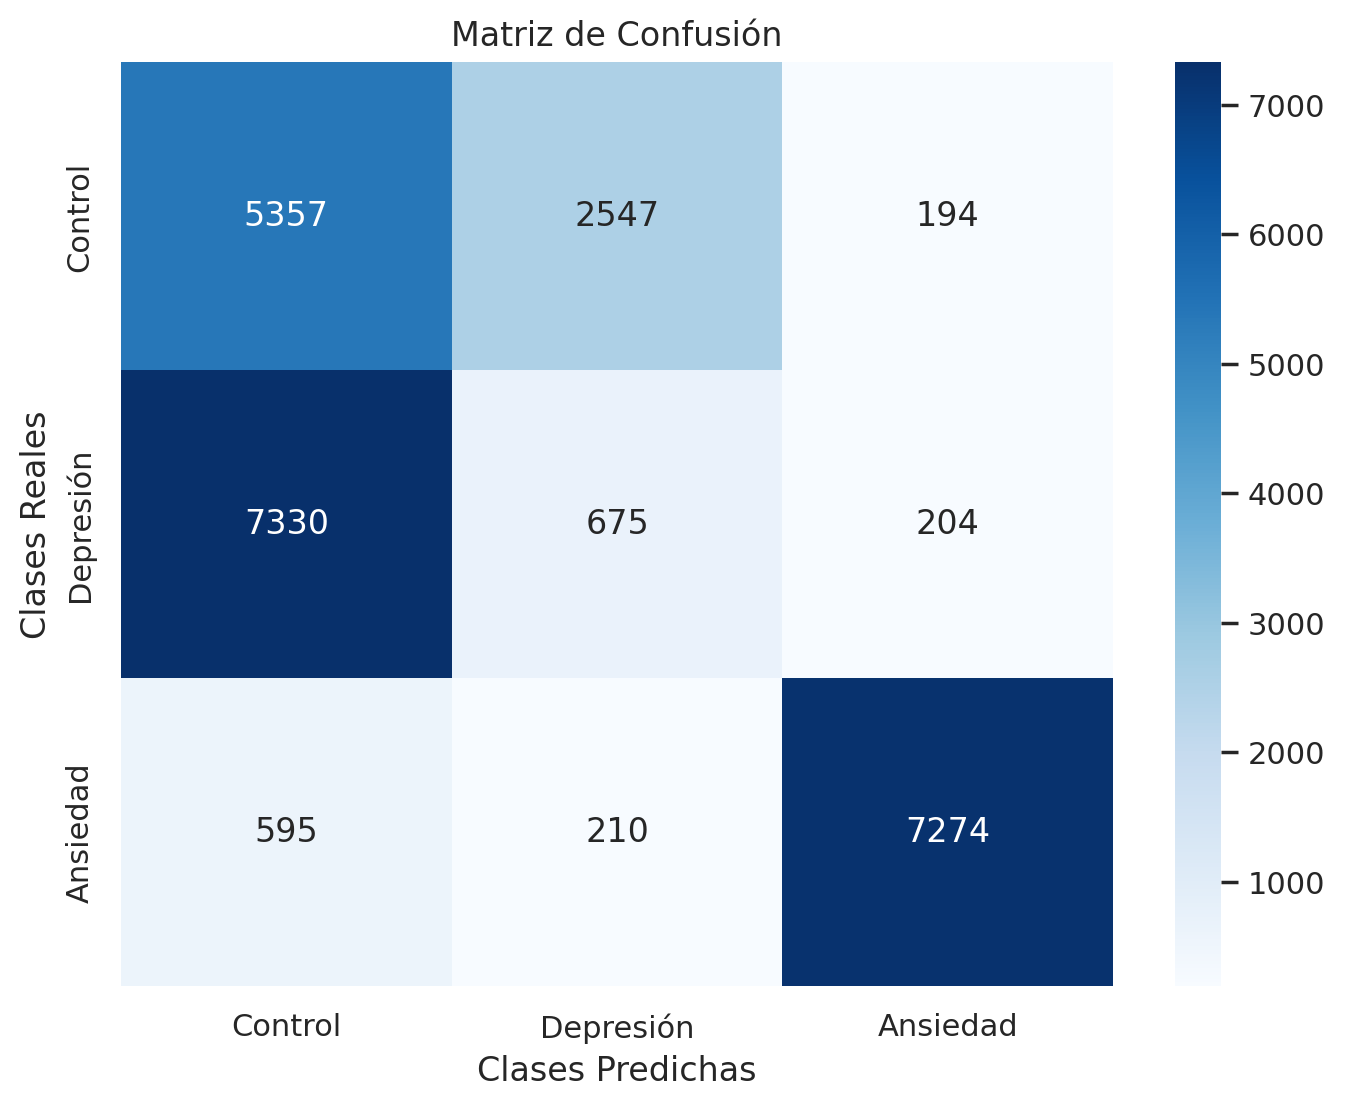

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(
    n_estimators=300,  # Número de árboles
    max_depth=100,  # Profundidad máxima de los árboles
    random_state=42,  # Semilla aleatoria para reproducibilidad
    n_jobs=-1  # Utilizar todos los núcleos de la CPU para procesamiento en paralelo
)

# Realiza validación cruzada con K=10
cv_scores = cross_val_score(random_forest_model, X_train, y_train, cv=10, scoring='accuracy')

# Imprime las puntuaciones de validación cruzada
print("Puntuaciones de Validación Cruzada:", cv_scores)

# Imprime la precisión promedio de la validación cruzada
print("Precisión Promedio (Validación Cruzada): {:.2f}".format(np.mean(cv_scores)))

# Calcula e imprime métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

print("\nMétricas en el conjunto de entrenamiento:")
print("Precisión: {:.2f}".format(accuracy_train))
print("Precisión: {:.2f}".format(precision_train))
print("Exhaustividad: {:.2f}".format(recall_train))
print("Puntuación F1: {:.2f}".format(f1_train))

# Calcula e imprime métricas en el conjunto de entrenamiento
y_test_pred = random_forest_model.predict(X_val)

accuracy_train_v = accuracy_score(y_val, y_test_pred)
precision_train_v = precision_score(y_val, y_test_pred, average='weighted')
recall_train_v = recall_score(y_val, y_test_pred, average='weighted')
f1_train_v = f1_score(y_val, y_test_pred, average='weighted')

print("\nMétricas en el conjunto de entrenamiento:")
print("Precisión: {:.2f}".format(accuracy_train_v))
print("Precisión: {:.2f}".format(precision_train_v))
print("Exhaustividad: {:.2f}".format(recall_train_v))
print("Puntuación F1: {:.2f}".format(f1_train_v))


In [ ]:

# Imprimir las métricas en entrenamiento y validación
print("Entrenamiento - Accuracy: {:.2f}%".format(100 * train_accuracy_mean))
print("Entrenamiento - Precision: {:.2f}%".format(100 * train_precision_mean))
print("Entrenamiento - Recall: {:.2f}%".format(100 * train_recall_mean))
print("Entrenamiento - F1 Score: {:.2f}%".format(100 * train_f1_mean))

print("\nValidación - Accuracy: {:.2f}%".format(100 * val_accuracy_mean))
print("Validación - Precision: {:.2f}%".format(100 * val_precision_mean))
print("Validación - Recall: {:.2f}%".format(100 * val_recall_mean))
print("Validación - F1 Score: {:.2f}%".format(100 * val_f1_mean))


In [ ]:
import joblib
import os
# Directorio para guardar modelos entrenados
model_dir = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/Modelos ya entrenados'
model_filename = 'TWEETS_depresivos (BoW))(random_forest K = 10).pkl'
model_path = os.path.join(model_dir, model_filename)
# Guardar el modelo entrenado
joblib.dump(random_forest_model, model_path)


# matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = random_forest_model.predict(X_val_fold)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
# y las columnas a las predicciones.
#
cm = confusion_matrix(y_val_fold, y_pred)

# Obtiene la proporción real de comentarios positivos,
# y la proporción etiquetados.
#
prop_real = np.sum(y_val_fold)/len(y_val_fold)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val_fold)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# Validación del modelo

Se explorará la curva de aprendizaje desde el 10% hasta 100% del conjunto de entrenamieto a través de una validación cruzada de 10.

Se almacenará la media de acierto sobre entrenamiento en las 10 ejecuciones correspondientes a cada tamaño en el vector train_scores_mean, y la desviación en train_scores_std. Hacer lo propio con los errores de test, cuya media se almacenará en test_scores_mean y su desviación en test_scores_std.

# Evaluación  del modelo

In [ ]:
# Importar las funciones necesarias
from sklearn.metrics import precision_score, recall_score, f1_score

# Aplicar transformaciones al conjunto de pruebas
data_test['TWEET_TEXT'] = data_test['TWEET_TEXT'].apply(removeHTML)
data_test['TWEET_TEXT'] = data_test['TWEET_TEXT'].apply(clean)
count_test = count_vect.transform(data_test['TWEET_TEXT'])

# Crear el conjunto de pruebas
X_test = count_test
y_test = data_test['trastorno'].values

# Predicciones en el conjunto de pruebas
y_test_pred = random_forest_model.predict(X_test)

# Calcular precisión en el conjunto de pruebas
precision_test = precision_score(y_test, y_test_pred)

# Calcular exhaustividad (recall) en el conjunto de pruebas
recall_test = recall_score(y_test, y_test_pred)

# Calcular puntuación F1 en el conjunto de pruebas

f1_test = f1_score(y_test, y_test_pred)
# Calcular exactitud en el conjunto de pruebas
accuracy_test = random_forest_model.score(X_test, y_test) * 100

# Mostrar precisión en el conjunto de pruebas
print("Precisión (test): {:.2f}".format(precision_test))

# Mostrar exhaustividad en el conjunto de pruebas
print("Recall (test): {:.2f}".format(recall_test))

# Mostrar puntuación F1 en el conjunto de pruebas
print("Puntuación F1 (test): {:.2f}".format(f1_test))

# Mostrar la exactitud en el conjunto de pruebas
print("Exactitud (test): {:.2f}%".format(accuracy_test))

In [ ]:
# Mostrar precisión en el conjunto de pruebas
print("Precisión (test): {:.2f}%".format(precision_test*100))

# Mostrar exhaustividad en el conjunto de pruebas
print("Exhaustividad (test): {:.2f}%".format(recall_test*100))

# Mostrar puntuación F1 en el conjunto de pruebas
print("Puntuación F1 (test): {:.2f}%".format(f1_test*100))

# Mostrar la exactitud en el conjunto de pruebas
print("Exactitud (test): {:.2f}%".format(accuracy_test))

# matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = random_forest_model.predict(X_test)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
# y las columnas a las predicciones.
#
cm = confusion_matrix(y_test, y_pred)

# Obtiene la proporción real de comentarios positivos,
# y la proporción etiquetados.
#
prop_real = np.sum(y_test)/len(y_test)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_test)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# MODELO ENTRENADO

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
import os

model_path ='/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/Modelos ya entrenados/TWEETS_depresivos (BoW))(random_forest K = 10).pkl'
# Cargar el modelo entrenado
loaded_model = joblib.load(model_path)

# Texto de ejemplo para predecir
new_tweet = "Me encanta levantarme un lunes... Afonica y con una 🤧 loca que no ne quiere dejar rápido... Todo para tener un geab día Jijiii 🤭🤭🤭"


# Preprocesamiento del texto
new_tweet_cleaned = clean(removeHTML(new_tweet))
new_tweet_extracted = extractTerms(new_tweet_cleaned)
new_tweet_combined = ' '.join(new_tweet_extracted)
new_tweet_tfidf = count_vect.transform([new_tweet_combined])

# Hacer la predicción y obtener las probabilidades de ambas clases
proba_prediction = loaded_model.predict_proba(new_tweet_tfidf)
control_prob = proba_prediction[0][0]  # Probabilidad de ser control
depresion_prob = proba_prediction[0][1]  # Probabilidad de ser ansiedad

# Imprimir el resultado de la predicción y las probabilidades
print(new_tweet)
print('------------------------------------------------------------------')
if proba_prediction[0][0] > proba_prediction[0][1]:
    print("Este tweet No es de ansiedad")
    print("Probabilidad de que el tweet No sea  de depresión: {:.2f}%".format(control_prob * 100))
    print("Probabilidad de que el tweet  sea de Depresión: {:.2f}%".format(depresion_prob * 100))
else:
    print("Este tweet es de ansiedad")
    print("Probabilidad de que el tweet No sea  de depresión: {:.2f}%".format(control_prob * 100))
    print("Probabilidad de que el tweet  sea de Depresión: {:.2f}%".format(depresion_prob * 100))